In [2]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load the rat dataset
ratData = pd.read_csv('rat2016.csv', parse_dates = [0])
ratData.count()

CreatedDate    17078
Longitude      17078
Latitude       17078
dtype: int64

In [3]:
ratData.head()

,CreatedDate,Longitude,Latitude
0,2016-01-01,-73.857150,40.806742
1,2016-01-01,-73.954813,40.612525
2,2016-01-01,-74.188306,40.541135
3,2016-01-01,-73.951252,40.778895
4,2016-01-01,-74.009348,40.650892


In [8]:
# Filter out data in Jan 2016
janRatFilter = (ratData['CreatedDate'] >= '2016-07-01') & (ratData['CreatedDate'] <= '2016-07-31')
janRat = ratData.loc[janRatFilter]
janRat.count()

CreatedDate    1750
Longitude      1750
Latitude       1750
dtype: int64

In [9]:
# Preprocess data to plot
janRatLocation = janRat[['Longitude', 'Latitude']]

m = folium.Map([40.707772, -74.012963], zoom_start=10)

# mark each station as a point
for index, row in janRatLocation.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=15,
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
    
# convert to (n, 2) nd-array format for heatmap
janRatList = janRatLocation[['Latitude', 'Longitude']].as_matrix()

# Plot heatmap
m.add_children(plugins.HeatMap(janRatList, radius=1))

In [5]:
# Read weather data
weather = pd.read_csv('weather.csv', parse_dates = [0])
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.0,0,0,0
1,2016-01-02,40,32,36.0,0,0,0
2,2016-01-03,45,35,40.0,0,0,0
3,2016-01-04,36,14,25.0,0,0,0
4,2016-01-05,29,11,20.0,0,0,0


In [6]:
# Count how many rats per day
ratDataEntries = ratData[['CreatedDate']]
ratDataEntries = ratDataEntries.groupby(['CreatedDate']).size().reset_index(name='RatCounts')
ratDataEntries.head()

,CreatedDate,RatCounts
0,2016-01-01,23
1,2016-01-02,23
2,2016-01-03,27
3,2016-01-04,32
4,2016-01-05,41


In [7]:
# Merge 2 data frames
def f_to_c(f):
    c = (f - 32) * (5.0/9.0)
    return round(c,2)

finalData = pd.concat([weather[['average temperature']], ratDataEntries[['RatCounts']]], axis=1)
finalData.columns = ['AvgTemp', 'RatCounts']
finalData['AvgTemp'] = finalData['AvgTemp'].apply(f_to_c)
finalData.head()

,AvgTemp,RatCounts
0,3.33,23
1,2.22,23
2,4.44,27
3,-3.89,32
4,-6.67,41


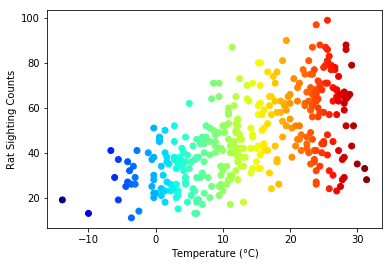

In [51]:
# Visualize data
X = finalData['AvgTemp'].values.reshape(-1, 1)
y = finalData['RatCounts']

plt.xlabel('Temperature (°C)')
plt.ylabel('Rat Sighting Counts')
plt.scatter(X, y, c=X, cmap="jet")

In [40]:
# Shuffle and split the data into training and testing subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

In [44]:
from sklearn.svm import SVR

linear_model = SVR(kernel='linear').fit(X_train, y_train) 
rbf_model = SVR(kernel='rbf').fit(X_train, y_train) 
poly_model = SVR(kernel='poly', degree=2).fit(X_train, y_train)

print("Linear model R2 score is: ", linear_model.score(X_test, y_test))
print("RBF model R2 score is: ", rbf_model.score(X_test, y_test))
print("Poly model R2 score is: ", poly_model.score(X_test, y_test))
print("\nLinear model gives the best results")

Linear model R2 score is:  0.468202843807
RBF model R2 score is:  0.264715423777
Poly model R2 score is:  0.390602295049


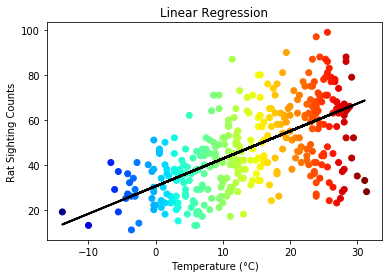

In [52]:
plt.xlabel('Temperature (°C)')
plt.ylabel('Rat Sighting Counts')
plt.scatter(X, y, c=X, cmap="jet")

y_lin = linear_model.predict(X_test)
plt.plot(X_test, y_lin, color='k', lw=2)
plt.title('Linear Regression')
plt.show()